In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile
import os

# --- CONFIGURATION ---
DRIVE_ZIP_PATH = "/content/drive/MyDrive/dentex_project/training_data.zip"
LOCAL_DATA_DIR = "/content/temp_data"

def unzip_data(zip_path, extract_to):
    if not os.path.exists(zip_path):
        print(f"Zip file not found: {zip_path}")
        return
    print(f"Unzipping {zip_path} to {extract_to}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Unzip complete.")

# 1. Unzip Training Data (only if not already done)
if not os.path.exists(LOCAL_DATA_DIR) or not os.listdir(LOCAL_DATA_DIR):
    os.makedirs(LOCAL_DATA_DIR, exist_ok=True)
    unzip_data(DRIVE_ZIP_PATH, LOCAL_DATA_DIR)

Unzipping /content/drive/MyDrive/dentex_project/training_data.zip to /content/temp_data...
Unzip complete.


In [1]:
!pip install ultralytics lightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 70.5 MB/s eta 0:00:00


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

DENTEX QUADRANT DETECTION - SSL FINE-TUNING PIPELINE
✅ Found SSL Weights: yolov8n_dentex_ssl.pt
CONVERTING DENTEX QUADRANT DATA TO YOLO FORMAT

📁 Source paths:
   Annotations: /content/temp_data/training_data/quadrant/train_quadrant.json
   Images: /content/temp_data/training_data/quadrant/xrays
   Found 693 images

🔄 Converting and copying files...


Processing images: 100%|██████████| 693/693 [00:19<00:00, 35.67it/s]



✅ Conversion complete! Converted 693 images.

SPLITTING AND ORGANIZING DATASET


Copying val: 100%|██████████| 104/104 [00:02<00:00, 48.02it/s]



✅ Dataset organized in: /content/dentex_quadrant_yolo

📝 YOLO config created: /content/dentex_quadrant_yolo/dentex_quadrant.yaml

TRAINING YOLOV8 FOR QUADRANT DETECTION

🚀 Initializing model from Custom SSL Weights: yolov8n_dentex_ssl.pt

🎯 Starting fine-tuning training...
Ultralytics 8.3.242 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dentex_quadrant_yolo/dentex_quadrant.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3, hsv_v=0.2, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, li

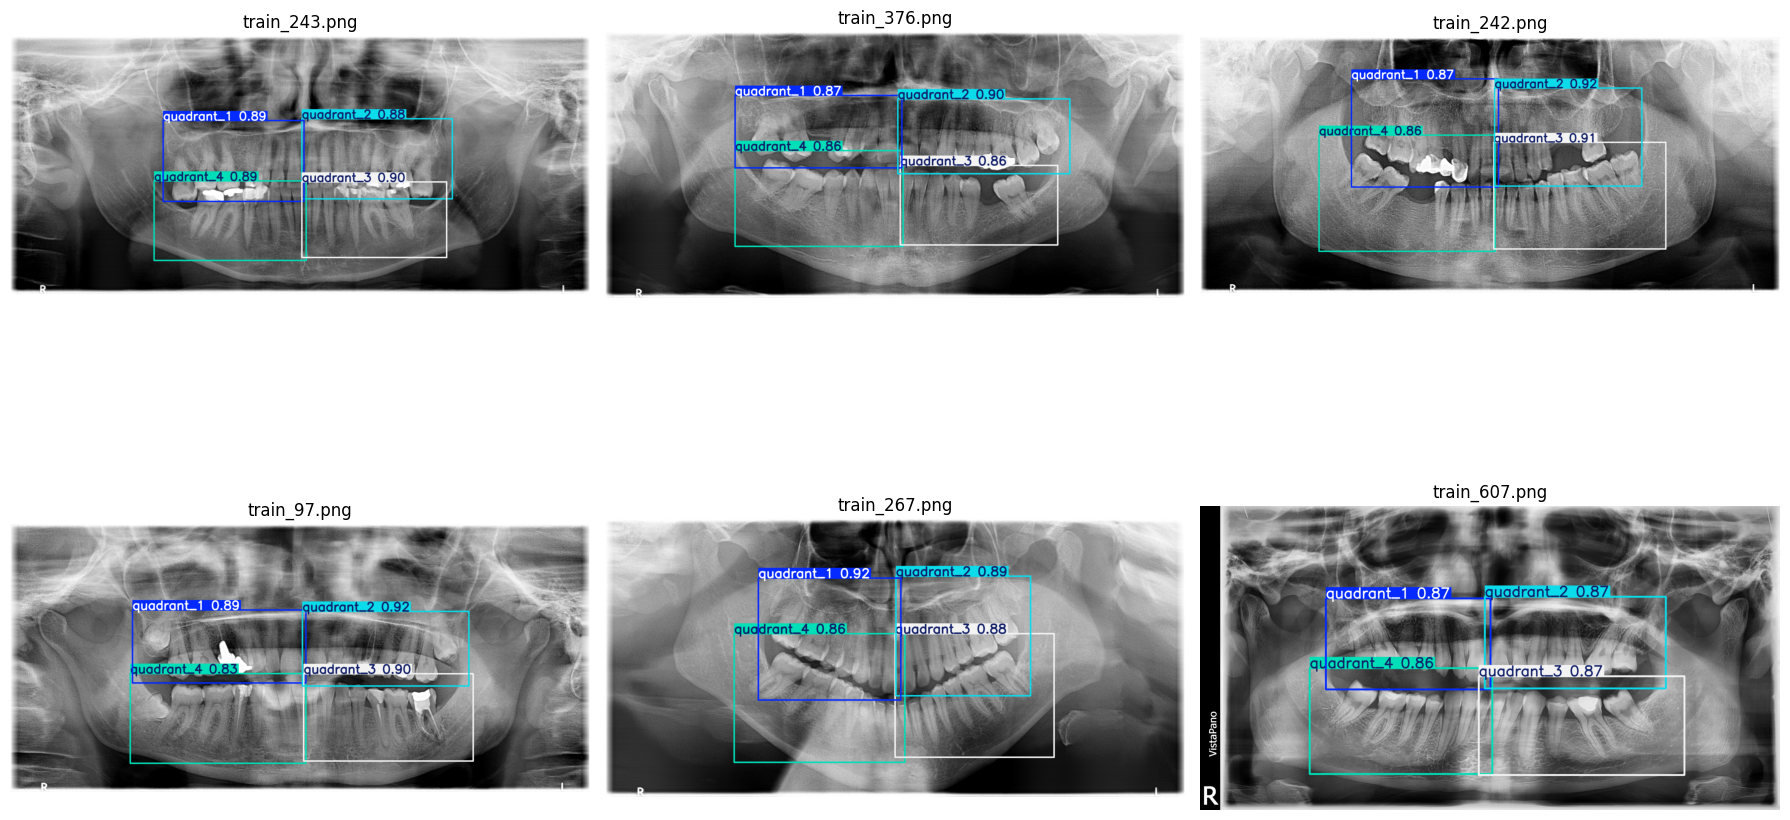


SAVING WEIGHTS TO GOOGLE DRIVE
✅ Saved Final Model: /content/drive/MyDrive/dentex_project/weights_stage1/quadrant_detector_ssl_finetuned.pt


In [ ]:
"""
DENTEX Challenge - Stage 1: Quadrant Detection with YOLOv8
Modified: Loads pre-trained SSL weights (yolov8n_dentex_ssl.pt) directly.
Optimized for Google Colab T4 GPU
"""

import os
import json
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import yaml
import torch
from ultralytics import YOLO

# ============================================================================
# FIXED CONVERSION FOR DENTEX STRUCTURE
# ============================================================================

def convert_dentex_quadrant_to_yolo(data_dir, output_dir):
    """Convert DENTEX quadrant annotations to YOLO format"""
    print("=" * 80)
    print("CONVERTING DENTEX QUADRANT DATA TO YOLO FORMAT")
    print("=" * 80)

    data_path = Path(data_dir)
    annotation_file = data_path / 'train_quadrant.json'
    images_dir = data_path / 'xrays'

    if not annotation_file.exists():
        raise FileNotFoundError(f"Annotation file not found: {annotation_file}")
    if not images_dir.exists():
        raise FileNotFoundError(f"Images directory not found: {images_dir}")

    print(f"\n📁 Source paths:")
    print(f"   Annotations: {annotation_file}")
    print(f"   Images: {images_dir}")
    print(f"   Found {len(list(images_dir.glob('*.png')))} images")

    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)

    # Category mapping: 1->0, 2->1, 3->2, 4->3
    category_to_yolo = {}
    for cat in coco_data['categories']:
        category_to_yolo[cat['id']] = int(cat['name']) - 1

    # Output setup
    output_path = Path(output_dir)
    labels_dir = output_path / 'labels'
    images_out_dir = output_path / 'images'
    labels_dir.mkdir(parents=True, exist_ok=True)
    images_out_dir.mkdir(parents=True, exist_ok=True)

    image_info = {img['id']: img for img in coco_data['images']}
    annotations_by_image = {}
    for anno in coco_data['annotations']:
        img_id = anno['image_id']
        if img_id not in annotations_by_image: annotations_by_image[img_id] = []
        annotations_by_image[img_id].append(anno)

    print(f"\n🔄 Converting and copying files...")
    converted_count = 0

    for img_id, img_data in tqdm(image_info.items(), desc="Processing images"):
        img_filename = img_data['file_name']
        src_img_path = images_dir / img_filename

        if not src_img_path.exists(): continue

        # Copy image
        shutil.copy(src_img_path, images_out_dir / img_filename)

        # Create Label
        if img_id in annotations_by_image:
            yolo_annotations = []
            for anno in annotations_by_image[img_id]:
                yolo_class = category_to_yolo[anno['category_id']]
                x, y, w, h = anno['bbox']

                # Normalize
                x_center = (x + w / 2) / img_data['width']
                y_center = (y + h / 2) / img_data['height']
                norm_w = w / img_data['width']
                norm_h = h / img_data['height']

                yolo_annotations.append(f"{yolo_class} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}")

            with open(labels_dir / (Path(img_filename).stem + '.txt'), 'w') as f:
                f.write('\n'.join(yolo_annotations))
            converted_count += 1

    print(f"\n✅ Conversion complete! Converted {converted_count} images.")
    return converted_count


def split_and_organize_dataset(temp_dir, final_dir, train_ratio=0.85):
    """Split converted data into train/val"""
    print("\n" + "=" * 80)
    print("SPLITTING AND ORGANIZING DATASET")
    print("=" * 80)

    temp_path = Path(temp_dir)
    image_files = sorted(list((temp_path / 'images').glob('*.png')))

    np.random.seed(42)
    indices = np.random.permutation(len(image_files))
    split_idx = int(len(image_files) * train_ratio)

    train_imgs = [image_files[i] for i in indices[:split_idx]]
    val_imgs = [image_files[i] for i in indices[split_idx:]]

    final_path = Path(final_dir)
    for split in ['train', 'val']:
        (final_path / split / 'images').mkdir(parents=True, exist_ok=True)
        (final_path / split / 'labels').mkdir(parents=True, exist_ok=True)

    def copy_files(file_list, split):
        for img_path in tqdm(file_list, desc=f"Copying {split}"):
            shutil.copy(img_path, final_path / split / 'images' / img_path.name)
            lbl_src = temp_path / 'labels' / (img_path.stem + '.txt')
            if lbl_src.exists():
                shutil.copy(lbl_src, final_path / split / 'labels' / lbl_src.name)

    copy_files(train_imgs, 'train')
    copy_files(val_imgs, 'val')
    print(f"\n✅ Dataset organized in: {final_dir}")


def create_yolo_config(dataset_dir):
    """Create YAML configuration file"""
    config = {
        'path': str(Path(dataset_dir).absolute()),
        'train': 'train/images',
        'val': 'val/images',
        'nc': 4,
        'names': ['quadrant_1', 'quadrant_2', 'quadrant_3', 'quadrant_4']
    }
    config_path = Path(dataset_dir) / 'dentex_quadrant.yaml'
    with open(config_path, 'w') as f:
        yaml.dump(config, f)
    print(f"\n📝 YOLO config created: {config_path}")
    return str(config_path)

# ============================================================================
# TRAINING WITH YOLOV8
# ============================================================================

def train_yolo_quadrant_detector(config_path, weights_path, epochs=100, imgsz=640, batch=16):
    """
    Train YOLOv8 model starting from Custom SSL Weights
    """
    print("\n" + "=" * 80)
    print("TRAINING YOLOV8 FOR QUADRANT DETECTION")
    print("=" * 80)

    # Initialize model from SSL weights
    print(f"\n🚀 Initializing model from Custom SSL Weights: {weights_path}")

    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"❌ Critical Error: The SSL weights file '{weights_path}' was not found.")

    model = YOLO(weights_path)

    # Train
    print(f"\n🎯 Starting fine-tuning training...")
    results = model.train(
        data=config_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        device=0,
        patience=20,
        save=True,
        cache=True,
        project='dentex_runs',
        name='quadrant_yolo8n_ssl_finetuned',
        exist_ok=True,
        # Hypers
        lr0=0.01,
        lrf=0.01,
        box=7.5,
        cls=0.5,
        dfl=1.5,
        hsv_h=0.015,
        hsv_s=0.3,
        hsv_v=0.2,
        degrees=5.0,
        translate=0.1,
        scale=0.2,
        flipud=0.0,
        fliplr=0.5,
        mosaic=1.0,
        mixup=0.1
    )

    print("\n✅ Training complete!")
    print(f"   Best model: {results.save_dir}/weights/best.pt")
    return model, results


# ============================================================================
# EVALUATION AND VISUALIZATION
# ============================================================================

def evaluate_model(model, config_path):
    """Evaluate on validation set"""
    print("\n" + "=" * 80)
    print("EVALUATING MODEL")
    print("=" * 80)
    metrics = model.val(data=config_path)
    print(f"\n📊 mAP50: {metrics.box.map50:.4f}")
    print(f"   mAP50-95: {metrics.box.map:.4f}")
    return metrics

def visualize_predictions(model, val_images_dir, num_samples=6, save_path='predictions.png'):
    """Visualize predictions"""
    print("\n" + "=" * 80)
    print("VISUALIZING PREDICTIONS")
    print("=" * 80)

    val_path = Path(val_images_dir)
    image_files = list(val_path.glob('*.png'))
    if not image_files: return

    np.random.seed(42)
    sample_images = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for idx, img_path in enumerate(sample_images):
        results = model(str(img_path), verbose=False)
        img_rgb = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(img_path.name)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    print(f"✅ Saved visualization to: {save_path}")
    plt.show()

def save_results_to_drive(final_model_path, drive_folder_name="dentex_project"):
    """Saves final fine-tuned weights to Drive"""
    from google.colab import drive

    print("\n" + "=" * 80)
    print("SAVING WEIGHTS TO GOOGLE DRIVE")
    print("=" * 80)

    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    dest_dir = Path(f"/content/drive/MyDrive/{drive_folder_name}/weights_stage1")
    dest_dir.mkdir(parents=True, exist_ok=True)

    if os.path.exists(final_model_path):
        dst = dest_dir / "quadrant_detector_ssl_finetuned.pt"
        shutil.copy(final_model_path, dst)
        print(f"✅ Saved Final Model: {dst}")
    else:
        print(f"⚠️  Missing file: {final_model_path}")

# ============================================================================
# COMPLETE PIPELINE
# ============================================================================

def run_complete_pipeline():
    print("\n" + "=" * 80)
    print("DENTEX QUADRANT DETECTION - SSL FINE-TUNING PIPELINE")
    print("=" * 80)

    # 1. Define Paths
    SOURCE_DATA_DIR = "/content/temp_data/training_data/quadrant"
    TEMP_YOLO_DIR = "/content/yolo_temp"
    FINAL_YOLO_DIR = "/content/dentex_quadrant_yolo"

    # === PATH TO YOUR PRE-TRAINED SSL WEIGHTS ===
    # Assuming you uploaded it to the Colab root directory
    SSL_WEIGHTS_PATH = "yolov8n_dentex_ssl.pt"

    # Check if weights exist
    if not os.path.exists(SSL_WEIGHTS_PATH):
        # Fallback to check Drive if not in root
        drive_path = "/content/drive/MyDrive/dentex_project/weights/yolov8n_dentex_ssl.pt"
        if os.path.exists(drive_path):
            print(f"✅ Found weights in Drive: {drive_path}")
            SSL_WEIGHTS_PATH = drive_path
        else:
            print(f"❌ ERROR: Could not find '{SSL_WEIGHTS_PATH}'")
            print("   Please upload your self-supervised weights file to Colab files!")
            # Uncomment below to force error, or comment to fallback to standard COCO
            # raise FileNotFoundError("Missing SSL weights")
            print("⚠️ Falling back to standard yolov8n.pt (NOT RECOMMENDED)")
            SSL_WEIGHTS_PATH = 'yolov8n.pt'
    else:
        print(f"✅ Found SSL Weights: {SSL_WEIGHTS_PATH}")

    # 2. Prepare Data
    convert_dentex_quadrant_to_yolo(SOURCE_DATA_DIR, TEMP_YOLO_DIR)
    split_and_organize_dataset(TEMP_YOLO_DIR, FINAL_YOLO_DIR, train_ratio=0.85)
    config_path = create_yolo_config(FINAL_YOLO_DIR)

    # 3. Train (Fine-tune) using SSL Weights
    model, results = train_yolo_quadrant_detector(
        config_path,
        weights_path=SSL_WEIGHTS_PATH, # <--- Using SSL weights
        epochs=100,
        imgsz=640,
        batch=16
    )

    # 4. Evaluate & Visualize
    evaluate_model(model, config_path)
    val_img_dir = Path(FINAL_YOLO_DIR) / 'val' / 'images'
    visualize_predictions(model, val_img_dir)

    return model

if __name__ == "__main__":
    # Run pipeline
    model = run_complete_pipeline()

    # Save final result
    final_model_path = "dentex_runs/quadrant_yolo8n_ssl_finetuned/weights/best.pt"
    save_results_to_drive(final_model_path)

In [ ]:
# ==============================================================================
# 1. GENERATION FUNCTION (With Correct ID Logic)
# ==============================================================================
def create_stage2_dataset_final(json_path, images_dir, stage1_model_path, output_dir, padding_pct=0.1):
    print("="*80)
    print("🚀 GENERATING STAGE 2 DATASET (TEETH ENUMERATION)")
    print("="*80)

    # Setup Paths
    dest_path = Path(output_dir)
    if dest_path.exists(): shutil.rmtree(dest_path) # Clean start
    (dest_path / 'images').mkdir(parents=True, exist_ok=True)
    (dest_path / 'labels').mkdir(parents=True, exist_ok=True)

    # Load JSON
    print(f"📂 Loading annotations: {json_path}")
    with open(json_path, 'r') as f:
        coco = json.load(f)

    # Load Stage 1 Model
    print(f"🤖 Loading Stage 1 Model: {stage1_model_path}")
    if not os.path.exists(stage1_model_path):
        raise FileNotFoundError(f"Stage 1 model not found at {stage1_model_path}")
    model = YOLO(stage1_model_path)

    # Map annotations to Image ID
    img_to_anns = {}
    if 'annotations' in coco:
        for ann in coco['annotations']:
            img_id = ann['image_id']
            if img_id not in img_to_anns: img_to_anns[img_id] = []
            img_to_anns[img_id].append(ann)

    stats = {'images': 0, 'crops': 0, 'teeth': 0}

    # Process Images
    images_list = coco.get('images', [])
    for img_info in tqdm(images_list, desc="Processing X-rays"):
        img_id = img_info['id']
        fname = img_info['file_name']
        src_path = Path(images_dir) / fname

        if not src_path.exists(): continue

        # 1. Inference (Find Quadrants)
        results = model.predict(str(src_path), verbose=False, conf=0.25)

        img = cv2.imread(str(src_path))
        if img is None: continue
        h_img, w_img = img.shape[:2]

        gt_teeth = img_to_anns.get(img_id, [])
        if not gt_teeth: continue

        # 2. Process Quadrants
        for box in results[0].boxes:
            coords = box.xyxy[0].cpu().numpy()
            q_cls = int(box.cls[0].item()) + 1

            qx1, qy1, qx2, qy2 = coords
            qw, qh = qx2 - qx1, qy2 - qy1

            # Padding
            pad_x = int(qw * padding_pct)
            pad_y = int(qh * padding_pct)

            crop_x1 = max(0, int(qx1 - pad_x))
            crop_y1 = max(0, int(qy1 - pad_y))
            crop_x2 = min(w_img, int(qx2 + pad_x))
            crop_y2 = min(h_img, int(qy2 + pad_y))

            crop_w = crop_x2 - crop_x1
            crop_h = crop_y2 - crop_y1

            if crop_w < 50 or crop_h < 50: continue

            # 3. Map Teeth
            label_lines = []
            for tooth in gt_teeth:
                if 'bbox' not in tooth: continue
                tx, ty, tw, th = tooth['bbox']

                tx_center = tx + tw/2
                ty_center = ty + th/2

                if (crop_x1 < tx_center < crop_x2) and (crop_y1 < ty_center < crop_y2):
                    new_cx = (tx_center - crop_x1) / crop_w
                    new_cy = (ty_center - crop_y1) / crop_h
                    new_w = tw / crop_w
                    new_h = th / crop_h

                    # --- CORRECTED ID LOGIC ---
                    cat1 = tooth.get('category_id_1', 0)
                    cat2 = tooth.get('category_id_2', 0)

                    # Formula: (Quadrant_Index * 8) + Tooth_Index
                    # This maps 4 quadrants * 8 teeth -> 0-31 unique IDs
                    final_cls = (cat1 * 8) + cat2

                    if 0 <= final_cls <= 31 and 0 < new_cx < 1 and 0 < new_cy < 1:
                        label_lines.append(f"{final_cls} {new_cx:.6f} {new_cy:.6f} {new_w:.6f} {new_h:.6f}")
                        stats['teeth'] += 1

            if label_lines:
                crop_name = f"{Path(fname).stem}_q{q_cls}"
                cv2.imwrite(str(dest_path / 'images' / f"{crop_name}.jpg"), img[crop_y1:crop_y2, crop_x1:crop_x2])
                with open(dest_path / 'labels' / f"{crop_name}.txt", 'w') as f:
                    f.write('\n'.join(label_lines))
                stats['crops'] += 1

        stats['images'] += 1

    print(f"\n✅ Generation Complete! Created {stats['crops']} crops.")
    print(f"   Mapped {stats['teeth']} teeth across 32 classes.")
    return stats['crops'] > 0

In [ ]:
# ==============================================================================
# 2. SPLITTER
# ==============================================================================
def split_dataset_robust(base_dir, train_ratio=0.85):
    print("\n📦 Organizing Dataset...")
    base = Path(base_dir)
    images_dir = base / 'images'
    labels_dir = base / 'labels'

    all_images = sorted(list(images_dir.glob('*.jpg')))

    if len(all_images) == 0:
        raise FileNotFoundError(f"❌ No images found in {images_dir}.")

    # Shuffle
    np.random.seed(42)
    indices = np.random.permutation(len(all_images))
    split_idx = int(len(all_images) * train_ratio)

    for split in ['train', 'val']:
        (base / split / 'images').mkdir(parents=True, exist_ok=True)
        (base / split / 'labels').mkdir(parents=True, exist_ok=True)

    for i, idx in enumerate(tqdm(indices, desc="Moving files")):
        split = 'train' if i < split_idx else 'val'
        img_path = all_images[idx]
        shutil.move(str(img_path), str(base / split / 'images' / img_path.name))

        label_name = img_path.stem + '.txt'
        label_src = labels_dir / label_name
        if label_src.exists():
            shutil.move(str(label_src), str(base / split / 'labels' / label_name))


In [ ]:
# ==============================================================================
# 3. EXECUTION
# ==============================================================================
# PATHS
JSON_FILE = "/content/temp_data/training_data/quadrant_enumeration/train_quadrant_enumeration.json"
IMAGES_DIR = "/content/temp_data/training_data/quadrant_enumeration/xrays"
STAGE1_MODEL = "/content/best.pt"
OUTPUT_DIR = "/content/dentex_stage2_yolo"

# A. Generate
success = create_stage2_dataset_final(JSON_FILE, IMAGES_DIR, STAGE1_MODEL, OUTPUT_DIR)

if success:
    # B. Split
    split_dataset_robust(OUTPUT_DIR)

🚀 GENERATING STAGE 2 DATASET (TEETH ENUMERATION)
📂 Loading annotations: /content/temp_data/training_data/quadrant_enumeration/train_quadrant_enumeration.json
🤖 Loading Stage 1 Model: /content/best.pt


Processing X-rays: 100%|██████████| 634/634 [02:00<00:00,  5.26it/s]



✅ Generation Complete! Created 2540 crops.
   Mapped 26145 teeth across 32 classes.

📦 Organizing Dataset...


Moving files: 100%|██████████| 2528/2528 [00:00<00:00, 10747.90it/s]


In [ ]:
# C. Config
print("\n📝 Creating Config...")
config = {
    'path': str(Path(OUTPUT_DIR).absolute()),
    'train': 'train/images',
    'val': 'val/images',
    'nc': 32, # Correctly set to 32 now
    'names': [f"tooth_{i}" for i in range(32)]
}
config_path = Path(OUTPUT_DIR) / 'dentex_stage2.yaml'
with open(config_path, 'w') as f:
    yaml.dump(config, f)

# D. Train with Custom SimCLR Weights
print("\n🚀 Starting Stage 2 Training (Using Custom SimCLR Weights)...")

# 1. Define the path to your custom weights
ssl_weights_path = '/content/yolov8n_dentex_ssl.pt'

# 2. Check if they exist (Safety check)
if os.path.exists(ssl_weights_path):
    print(f"✅ Found custom weights: {ssl_weights_path}")
    print("   -> Loading YOLOv8n (Nano) architecture with SSL pre-training.")

    # LOAD YOUR CUSTOM MODEL HERE
    model = YOLO(ssl_weights_path)

    # Train
    model.train(
        data=str(config_path),
        epochs=50,
        imgsz=640,
        batch=16,
        project='dentex_runs',
        name='enumeration_stage2_ssl', # Changed name to reflect SSL usage
        fliplr=0.0 # CRITICAL: No horizontal flipping
    )

else:
    print(f"⚠️ WARNING: Custom weights not found at {ssl_weights_path}")
    print("   -> Falling back to standard YOLOv8n.pt (COCO weights)")

    model = YOLO('yolov8n.pt') # Must use Nano to match your intent, or 's' if you prefer better accuracy over SSL
    model.train(
        data=str(config_path),
        epochs=50,
        imgsz=640,
        batch=16,
        project='dentex_runs',
        name='enumeration_stage2_coco',
        fliplr=0.0
    )


📝 Creating Config...

🚀 Starting Stage 2 Training (Using Custom SimCLR Weights)...
✅ Found custom weights: /content/yolov8n_dentex_ssl.pt
   -> Loading YOLOv8n (Nano) architecture with SSL pre-training.
Ultralytics 8.3.242 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dentex_stage2_yolo/dentex_stage2.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.0, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0

🖼️ Processing: train_313.png


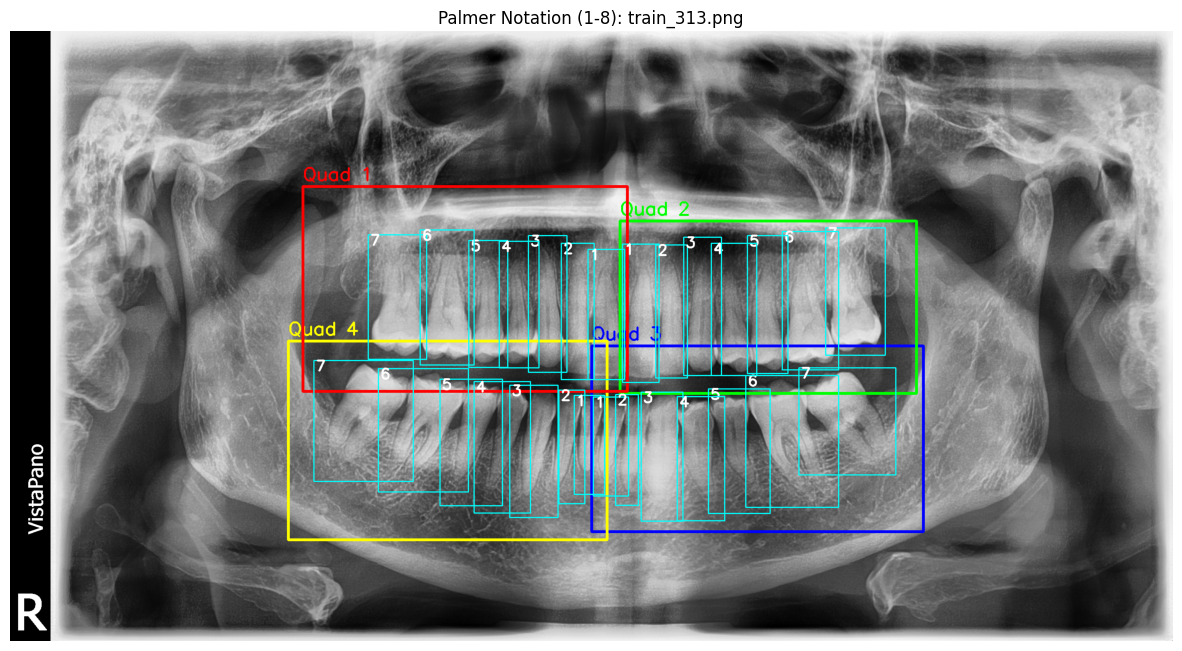

In [ ]:
import random
import torchvision
def visualize_palmer_notation(image_path, stage1_path, stage2_path):
    print(f"🖼️ Processing: {Path(image_path).name}")

    # 1. Load Models
    model_s1 = YOLO(stage1_path)
    model_s2 = YOLO(stage2_path)

    # 2. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        print("❌ Error: Could not load image.")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h_img, w_img = img.shape[:2]
    canvas = img_rgb.copy()

    # 3. RUN STAGE 1: Detect Quadrants
    results_s1 = model_s1.predict(img, verbose=False, conf=0.5)

    global_detections = []

    # Colors: Q1=Red, Q2=Green, Q3=Blue, Q4=Yellow
    quad_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]

    for box in results_s1[0].boxes:
        coords = box.xyxy[0].cpu().numpy()
        q_cls = int(box.cls[0].item()) # 0-3
        qx1, qy1, qx2, qy2 = map(int, coords)

        # Draw Quadrant Box
        cv2.rectangle(canvas, (qx1, qy1), (qx2, qy2), quad_colors[q_cls], 5)

        # Label the Quadrant (e.g., "Quad 1")
        # Placing it at the top-left corner of the quadrant box
        label_text = f"Quad {q_cls+1}"
        cv2.putText(canvas, label_text, (qx1, qy1-15),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, quad_colors[q_cls], 4)

        # 4. PREPARE CROP (With 10% Padding)
        qw, qh = qx2 - qx1, qy2 - qy1
        pad_x = int(qw * 0.1)
        pad_y = int(qh * 0.1)

        crop_x1 = max(0, qx1 - pad_x)
        crop_y1 = max(0, qy1 - pad_y)
        crop_x2 = min(w_img, qx2 + pad_x)
        crop_y2 = min(h_img, qy2 + pad_y)

        crop_img = img[crop_y1:crop_y2, crop_x1:crop_x2]
        if crop_img.size == 0: continue

        # 5. RUN STAGE 2
        results_s2 = model_s2.predict(crop_img, verbose=False, conf=0.25)

        for t_box in results_s2[0].boxes:
            t_coords = t_box.xyxy[0].cpu().numpy()
            t_conf = t_box.conf[0].item()
            t_cls = int(t_box.cls[0].item()) # 0-31

            tx1, ty1, tx2, ty2 = t_coords

            # Map to Global
            gx1 = float(tx1 + crop_x1)
            gy1 = float(ty1 + crop_y1)
            gx2 = float(tx2 + crop_x1)
            gy2 = float(ty2 + crop_y1)

            global_detections.append([gx1, gy1, gx2, gy2, t_conf, t_cls])

    # 6. APPLY GLOBAL NMS
    if len(global_detections) > 0:
        det_tensor = torch.tensor(global_detections)
        boxes = det_tensor[:, :4]
        scores = det_tensor[:, 4]
        classes = det_tensor[:, 5]

        # Class-aware NMS
        max_coordinate = boxes.max()
        offsets = classes * (max_coordinate + 1)
        boxes_for_nms = boxes + offsets[:, None]
        keep_indices = torchvision.ops.nms(boxes_for_nms, scores, 0.5)

        # 7. DRAW FILTERED BOXES
        for idx in keep_indices:
            x1, y1, x2, y2, conf, cls_id = global_detections[idx]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cls_id = int(cls_id)

            # --- NUMBERING LOGIC CHANGE ---
            # 1. Determine which Quadrant this tooth belongs to based on Class ID
            # 0-7=Q1, 8-15=Q2, 16-23=Q3, 24-31=Q4
            quad_idx = cls_id // 8

            # 2. Determine Tooth Number (1-8)
            # 0->1, 1->2 ... 7->8
            tooth_num = (cls_id % 8) + 1

            # Label string: just the number "1", "2", etc.
            label_str = str(tooth_num)

            # Color: Match the quadrant color for visual consistency?
            # Or keep Cyan for all teeth? Let's use Cyan to contrast with Quad box.
            box_color = (0, 255, 255) # Cyan

            cv2.rectangle(canvas, (x1, y1), (x2, y2), box_color, 2)

            # Draw Text inside the box (Big and Bold)
            cv2.putText(canvas, label_str, (x1 + 5, y1 + 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)

    # Show Result
    plt.figure(figsize=(15, 10))
    plt.imshow(canvas)
    plt.axis('off')
    plt.title(f"Palmer Notation (1-8): {Path(image_path).name}")
    plt.show()

# ==========================================
# EXECUTE
# ==========================================
source_images_dir = Path("/content/temp_data/training_data/quadrant_enumeration/xrays")
all_images = list(source_images_dir.glob("*.png"))

if len(all_images) > 0:
    test_image = random.choice(all_images)

    stage1_model = "/content/best.pt"
    stage2_model = "/content/dentex_runs/enumeration_stage2_ssl/weights/best.pt"

    if Path(stage1_model).exists() and Path(stage2_model).exists():
        visualize_palmer_notation(test_image, stage1_model, stage2_model)
    else:
        print("❌ Error: Check model paths.")
else:
    print("❌ Error: No images found.")

In [ ]:
import json
import os
from pathlib import Path
from tqdm import tqdm

def inspect_disease_data(json_path):
    print(f"📂 Reading: {json_path}")
    if not os.path.exists(json_path):
        print("❌ File not found! Please check the path.")
        return

    with open(json_path, 'r') as f:
        data = json.load(f)

    # 1. Check Categories
    print("\n🔍 Disease Categories Found:")
    categories = {cat['id']: cat['name'] for cat in data.get('categories', [])}
    for cid, cname in categories.items():
        print(f"  - ID {cid}: {cname}")

    # 2. Check Annotations
    print("\n🔍 Annotation Sample:")
    if 'annotations' in data and len(data['annotations']) > 0:
        # Check first 5 annotations that correspond to these disease categories
        count = 0
        for ann in data['annotations']:
            cat_id = ann.get('category_id')

            # We want to see if the bounding box is small (lesion) or big (whole tooth)
            if cat_id in categories:
                bbox = ann['bbox'] # x, y, w, h
                area = ann['area']
                print(f"  - Label: '{categories[cat_id]}' | Bbox: {bbox} | Area: {area}")
                count += 1
                if count >= 5: break
    else:
        print("❌ No annotations found.")

# Update this path to your actual disease dataset file
# It is usually inside the 'quadrant_enumeration_disease' folder
DISEASE_JSON = "/content/temp_data/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json"

inspect_disease_data(DISEASE_JSON)

📂 Reading: /content/temp_data/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json

🔍 Disease Categories Found:

🔍 Annotation Sample:


In [ ]:
import json
import os

# Update this to the exact path you used
json_path = "/content/temp_data/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json"

if not os.path.exists(json_path):
    print(f"❌ Error: File not found at {json_path}")
else:
    with open(json_path, 'r') as f:
        data = json.load(f)

    print(f"📂 JSON Loaded. Root Keys: {list(data.keys())}")

    # 1. Inspect Categories (if key exists)
    if 'categories' in data:
        print(f"\n🔍 Categories List Length: {len(data['categories'])}")
        if len(data['categories']) > 0:
            print("First Category Entry:", json.dumps(data['categories'][0], indent=2))
    else:
        print("\n⚠️ 'categories' key MISSING from root.")

    # 2. Inspect Annotations (if key exists)
    if 'annotations' in data:
        print(f"\n🔍 Annotations List Length: {len(data['annotations'])}")
        if len(data['annotations']) > 0:
            print("First Annotation Entry:", json.dumps(data['annotations'][0], indent=2))

            # Check for unique keys in annotations
            keys_seen = set()
            for ann in data['annotations'][:10]:
                keys_seen.update(ann.keys())
            print(f"All keys found in annotations: {keys_seen}")
    else:
        print("\n⚠️ 'annotations' key MISSING from root.")

📂 JSON Loaded. Root Keys: ['images', 'annotations', 'categories_1', 'categories_2', 'categories_3']

⚠️ 'categories' key MISSING from root.

🔍 Annotations List Length: 3529
First Annotation Entry: {
  "iscrowd": 0,
  "image_id": 1,
  "bbox": [
    542.0,
    698.0,
    220.0,
    271.0
  ],
  "segmentation": [
    [
      621,
      703,
      573,
      744,
      542,
      885,
      580,
      945,
      650,
      969,
      711,
      883,
      762,
      807,
      748,
      741,
      649,
      698
    ]
  ],
  "id": 1,
  "area": 39683,
  "category_id_1": 3,
  "category_id_2": 7,
  "category_id_3": 0
}
All keys found in annotations: {'image_id', 'id', 'segmentation', 'area', 'iscrowd', 'category_id_1', 'category_id_3', 'bbox', 'category_id_2'}


In [ ]:
import json

json_path = "/content/temp_data/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json"

with open(json_path, 'r') as f:
    data = json.load(f)

print("🔍 Disease Classes (category_id_3):")
if 'categories_3' in data:
    for cat in data['categories_3']:
        print(f"  Class {cat['id']} -> {cat['name']}")
else:
    print("❌ No 'categories_3' found.")

🔍 Disease Classes (category_id_3):
  Class 0 -> Impacted
  Class 1 -> Caries
  Class 2 -> Periapical Lesion
  Class 3 -> Deep Caries


# stage 3 classification

In [ ]:
import os
import json
import cv2
import shutil
import random
import numpy as np
from pathlib import Path
from tqdm import tqdm

def create_disease_classification_dataset(json_path, images_dir, output_dir):
    print("="*80)
    print("🚀 GENERATING STAGE 3 DATASET (DISEASE CLASSIFICATION)")
    print("="*80)

    # 1. Setup Output Structure
    dest_path = Path(output_dir)
    if dest_path.exists(): shutil.rmtree(dest_path) # Clean start

    # Define Classes based on your inspection
    # Note: We use underscores to be safe for filenames
    class_names = {
        0: 'Impacted',
        1: 'Caries',
        2: 'Periapical_Lesion',
        3: 'Deep_Caries'
    }

    # Create Train/Val folders for each class
    for split in ['train', 'val']:
        for name in class_names.values():
            (dest_path / split / name).mkdir(parents=True, exist_ok=True)

    # 2. Load Annotations
    print(f"📂 Loading: {json_path}")
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Group annotations by image for efficiency
    img_to_anns = {}
    if 'annotations' in data:
        for ann in data['annotations']:
            img_id = ann['image_id']
            if img_id not in img_to_anns: img_to_anns[img_id] = []
            img_to_anns[img_id].append(ann)

    # 3. Process Images
    stats = {name: 0 for name in class_names.values()}
    total_crops = 0

    # Get image list and shuffle for random train/val split
    images_list = data.get('images', [])
    random.seed(42)
    random.shuffle(images_list)

    # 80% Train, 20% Val
    split_idx = int(len(images_list) * 0.8)

    for i, img_info in enumerate(tqdm(images_list, desc="Cropping Diseased Teeth")):
        split = 'train' if i < split_idx else 'val'

        img_id = img_info['id']
        fname = img_info['file_name']
        src_path = Path(images_dir) / fname

        # Check if image exists
        if not src_path.exists(): continue

        # Load Image
        img = cv2.imread(str(src_path))
        if img is None: continue
        h_img, w_img = img.shape[:2]

        # Get annotations for this image
        anns = img_to_anns.get(img_id, [])

        for ann in anns:
            # Check if this annotation has a disease label (category_id_3)
            # Some annotations might be healthy (if cat_3 is missing or different)
            disease_id = ann.get('category_id_3')

            if disease_id in class_names:
                class_name = class_names[disease_id]

                # Get Bounding Box [x, y, w, h]
                x, y, w, h = ann['bbox']

                # --- PADDING STRATEGY ---
                # We add context so the classifier sees the whole tooth + surrounding
                pad_x = int(w * 0.15) # 15% padding
                pad_y = int(h * 0.15)

                x1 = max(0, int(x - pad_x))
                y1 = max(0, int(y - pad_y))
                x2 = min(w_img, int(x + w + pad_x))
                y2 = min(h_img, int(y + h + pad_y))

                # Crop
                crop_img = img[y1:y2, x1:x2]
                if crop_img.size == 0: continue

                # Save
                # Unique filename: OriginalName_AnnID.jpg
                save_name = f"{Path(fname).stem}_id{ann['id']}.jpg"
                save_path = dest_path / split / class_name / save_name

                cv2.imwrite(str(save_path), crop_img)
                stats[class_name] += 1
                total_crops += 1

    print("\n✅ Generation Complete!")
    print(f"   Total Diseased Teeth Processed: {total_crops}")
    print("📊 Class Distribution:")
    for name, count in stats.items():
        print(f"   - {name}: {count}")

# === EXECUTE GENERATION ===
# Update these paths to match your folder structure
JSON_FILE = "/content/temp_data/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json"
IMAGES_DIR = "/content/temp_data/training_data/quadrant-enumeration-disease/xrays"
OUTPUT_DIR = "/content/dentex_disease_classifier"

create_disease_classification_dataset(JSON_FILE, IMAGES_DIR, OUTPUT_DIR)

🚀 GENERATING STAGE 3 DATASET (DISEASE CLASSIFICATION)
📂 Loading: /content/temp_data/training_data/quadrant-enumeration-disease/train_quadrant_enumeration_disease.json


Cropping Diseased Teeth: 100%|██████████| 705/705 [01:05<00:00, 10.83it/s]


✅ Generation Complete!
   Total Diseased Teeth Processed: 3529
📊 Class Distribution:
   - Impacted: 604
   - Caries: 2189
   - Periapical_Lesion: 158
   - Deep_Caries: 578


In [ ]:
from ultralytics import YOLO

def train_disease_classifier():
    print("\n" + "="*80)
    print("🦠 TRAINING STAGE 3: DISEASE CLASSIFIER")
    print("="*80)

    # 1. Initialize Model
    # We use 'yolov8s-cls.pt' (Small) or 'yolov8m-cls.pt' (Medium)
    # Classification models are very fast, so 'm' is often fine.
    model = YOLO('yolov8s-cls.pt')

    # 2. Train
    # YOLO automatically looks for 'train' and 'val' folders in the data path
    results = model.train(
        data='/content/dentex_disease_classifier',
        epochs=50,
        imgsz=224,      # 224x224 is standard for classification
        batch=32,
        project='dentex_runs',
        name='disease_classifier',

        # Augmentations (Crucial for medical data)
        augment=True,
        hsv_h=0.01,     # Slight color variation
        hsv_s=0.0,      # X-rays are grayscale, so saturation changes don't help much
        hsv_v=0.1,      # Brightness variation
        degrees=15.0,   # Rotation
        fliplr=0.5      # Horizontal flip IS allowed here (a cavity is a cavity, left or right)
    )

    print("✅ Training Complete!")
    return model

# Run Training
train_disease_classifier()


🦠 TRAINING STAGE 3: DISEASE CLASSIFIER
Ultralytics 8.3.242 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dentex_disease_classifier, degrees=15.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01, hsv_s=0.0, hsv_v=0.1, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=disease_classifier, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🏥 CLINICAL DIAGNOSIS: train_124.png


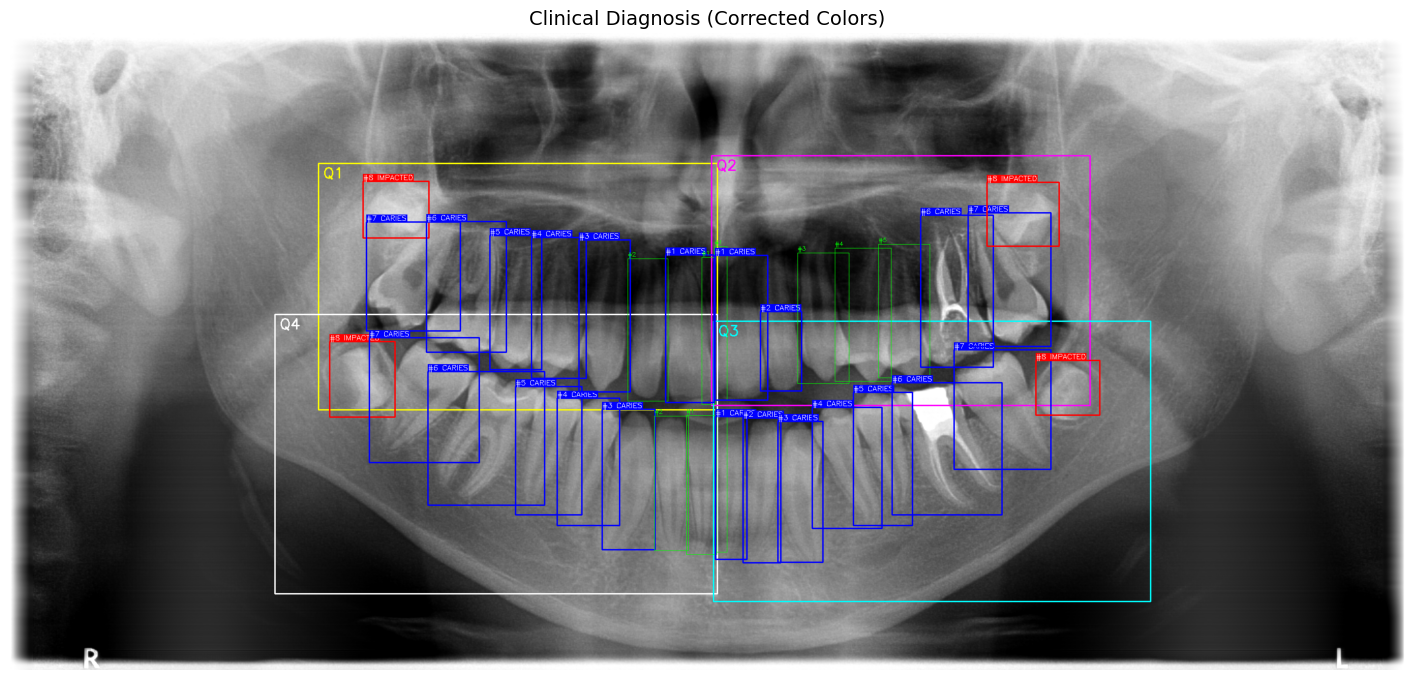

In [2]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO

def calculate_iou(box1, box2):
    """Calculates Intersection over Union (IoU) between two boxes."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - intersection_area
    if union_area == 0: return 0
    return intersection_area / union_area

def run_diagnosis_final(image_path, s1_path, s2_path, s3_path, conf_thresh=0.75):
    print(f"🏥 CLINICAL DIAGNOSIS: {Path(image_path).name}")

    model_s1 = YOLO(s1_path)
    model_s2 = YOLO(s2_path)
    model_s3 = YOLO(s3_path)

    img = cv2.imread(str(image_path))
    if img is None: return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h_img, w_img = img.shape[:2]
    canvas = img_rgb.copy()

    # --- 1. COLOR CONFIGURATION (BGR Format) ---
    colors = {
        'Healthy':           (0, 255, 0),    # Green
        'Impacted':          (255, 0, 0),    # Red
        'Periapical_Lesion': (128, 0, 128),  # Purple
        'Caries':            (0, 0, 255),    # Blue
        'Deep_Caries':       (0, 165, 255)   # Orange
    }

    quad_colors = [(255, 255, 0), (255, 0, 255), (0, 255, 255), (255, 255, 255)] # Q1-Q4 Colors

    severity_rank = {
        'Impacted': 100,
        'Deep_Caries': 90,
        'Periapical_Lesion': 80,
        'Caries': 50,
        'Healthy': 10
    }

    # --- 2. RUN PIPELINE ---
    results_s1 = model_s1.predict(img, verbose=False, conf=0.5)
    raw_detections = []

    # DRAW QUADRANTS FIRST (So they are behind the teeth)
    for box in results_s1[0].boxes:
        coords = map(int, box.xyxy[0].cpu().numpy())
        qx1, qy1, qx2, qy2 = coords
        q_cls = int(box.cls[0].item()) # 0-3

        # Draw Quadrant Box (Thin dashed style simulated by standard line)
        color = quad_colors[q_cls]
        cv2.rectangle(canvas, (qx1, qy1), (qx2, qy2), color, 2)
        cv2.putText(canvas, f"Q{q_cls+1}", (qx1 + 10, qy1 + 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

        # ... (Prepare crops for Stage 2) ...
        pad = 20
        cx1, cy1 = max(0, qx1-pad), max(0, qy1-pad)
        cx2, cy2 = min(w_img, qx2+pad), min(h_img, qy2+pad)
        q_crop = img[cy1:cy2, cx1:cx2]
        if q_crop.size == 0: continue

        # Stage 2: Teeth
        results_s2 = model_s2.predict(q_crop, verbose=False, conf=0.40)

        for t_box in results_s2[0].boxes:
            t_coords = t_box.xyxy[0].cpu().numpy()
            gx1 = int(t_coords[0] + cx1)
            gy1 = int(t_coords[1] + cy1)
            gx2 = int(t_coords[2] + cx1)
            gy2 = int(t_coords[3] + cy1)

            # Stage 3: Disease
            th_w, th_h = gx2 - gx1, gy2 - gy1
            pad_t = int(th_w * 0.1)
            tx1, ty1 = max(0, gx1 - pad_t), max(0, gy1 - pad_t)
            tx2, ty2 = min(w_img, gx2 + pad_t), min(h_img, gy2 + pad_t)
            t_crop = img[ty1:ty2, tx1:tx2]

            label = "Healthy"
            disease_conf = 0.0

            if t_crop.size > 0:
                res_s3 = model_s3.predict(t_crop, verbose=False)
                probs = res_s3[0].probs
                top1_idx = probs.top1
                conf = probs.top1conf.item()

                # Check threshold
                if conf > conf_thresh:
                    label = res_s3[0].names[top1_idx]
                    disease_conf = conf
                else:
                    label = "Healthy" # Default if low confidence

            priority = severity_rank.get(label, 0) + (disease_conf * 0.01)

            raw_detections.append({
                'box': [gx1, gy1, gx2, gy2],
                'cls': int(t_box.cls.item()),
                'disease': label,
                'disease_conf': disease_conf,
                'priority': priority
            })

    # --- 3. SEVERITY NMS ---
    if raw_detections:
        raw_detections.sort(key=lambda x: x['priority'], reverse=True)
        final_detections = []
        while raw_detections:
            current = raw_detections.pop(0)
            final_detections.append(current)
            keep_list = []
            for other in raw_detections:
                iou = calculate_iou(current['box'], other['box'])
                if iou < 0.40: keep_list.append(other)
            raw_detections = keep_list

        # Sort for drawing order (Left to Right generally looks better)
        final_detections.sort(key=lambda x: x['box'][0])

        # --- 4. DRAW TEETH ---
        for det in final_detections:
            x1, y1, x2, y2 = det['box']
            cls, disease = det['cls'], det['disease']
            tooth_num = (cls % 8) + 1
            color = colors.get(disease, (0, 255, 0))

            if disease == 'Healthy':
                # Minimalist
                cv2.rectangle(canvas, (x1, y1), (x2, y2), color, 1)
                cv2.putText(canvas, f"#{tooth_num}", (x1, y1-5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
            else:
                # Bold Alert
                cv2.rectangle(canvas, (x1, y1), (x2, y2), color, 2)
                # Label
                label_txt = f"#{tooth_num} {disease.upper()}"
                (w, h), _ = cv2.getTextSize(label_txt, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                cv2.rectangle(canvas, (x1, y1-15), (x1+w, y1), color, -1)
                cv2.putText(canvas, label_txt, (x1, y1-3),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    plt.figure(figsize=(18, 12))
    plt.imshow(canvas)
    plt.axis('off')
    plt.title("Clinical Diagnosis (Corrected Colors)", fontsize=14)
    plt.show()

# EXECUTE
S1 = "/content/bestQuadrantDetection.pt"
S2 = "/content/bestDentalenumeration.pt"
S3 = "/content/bestDiagnosisClasses.pt"
IMG = "/content/train_124.png"

if Path(S3).exists():
    run_diagnosis_final(IMG, S1, S2, S3, conf_thresh=0.90) # High threshold to hide false positives